# Acoustic FWI(VP) with entire data using Adam optimizer

## Author: M. Ravasi

This notebook performs acoustic FWI parametrized in velocity. In this example, the waveengine operator is wrapped into a torch operator and torch is tasked to compute the gradient: this is useful for more complex cases where the velocity model is for example parametrized with a network.

We will see later that a different strategy can be adopted if one prefers to fully decouple the gradient computation in two parts, one tasked with a torch graph (e.g., neural network parametrizing the velocity model) and one with the devito propagator. This way we can optimize the latter computation (potentially distributing it over multiple workers) whilst letting torch deal with the first part for us.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch

from functools import partial
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.optimize import minimize
from pylops.basicoperators import Identity

from functools import partial
from devito import configuration
from tqdm.notebook import tqdm

from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.loss.l2 import L2
from devitofwi.postproc.acoustic import create_mask_value, PostProcessVP
from devitofwi.deep.torchoperator import TorchOperator

configuration['log-level'] = 'ERROR'

/home/ravasim/Documents/2024/Projects/Devito-fwi/devitofwi/waveengine/acoustic.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# clear_devito_cache()

In [3]:
# Callback to track model error
def fwi_callback(xk, vp, vp_error):
    vp_error.append(np.linalg.norm((xk - vp.reshape(-1))/vp.reshape(-1)))

## Parameters 

In [4]:
# Model and aquisition parameters (in km, s, and Hz units)
par = {'nx':601,   'dx':0.015,    'ox':0,
       'nz':221,   'dz':0.015,    'oz':0,
       'ns':20,    'ds':0.300,    'os':1.,  'sz':0,
       'nr':300,   'dr':0.030,    'or':0,   'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':15,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

## Acquisition set-up

In [5]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

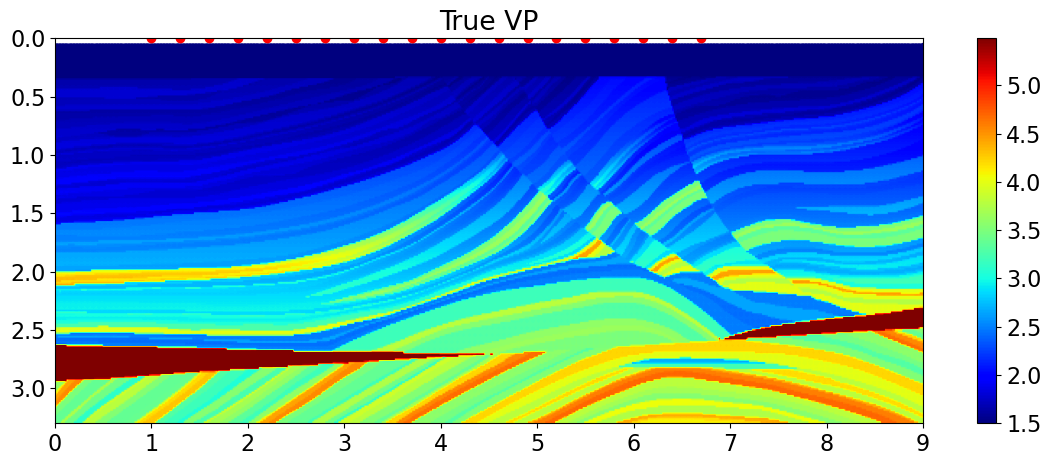

In [6]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = create_mask_value(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

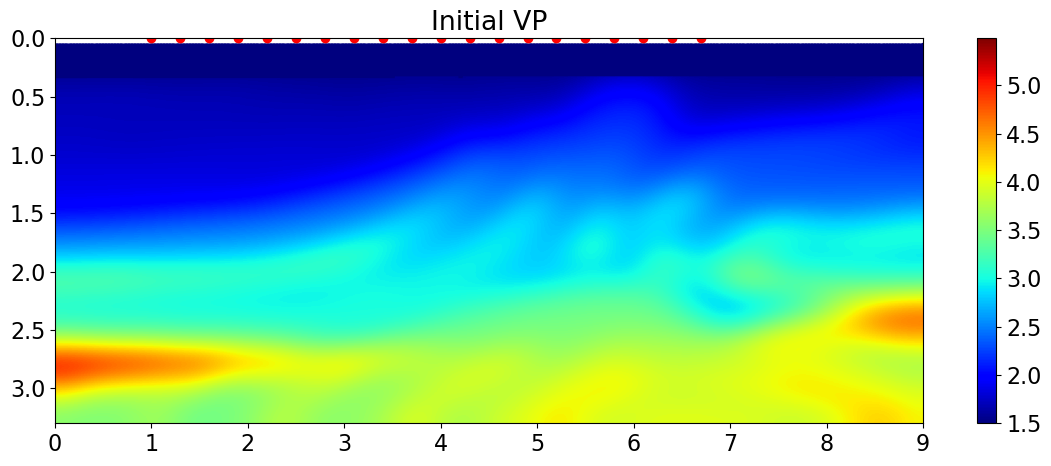

In [7]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [8]:
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vp=vp_true, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl)

In [9]:
# Model data
dobs, dtobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

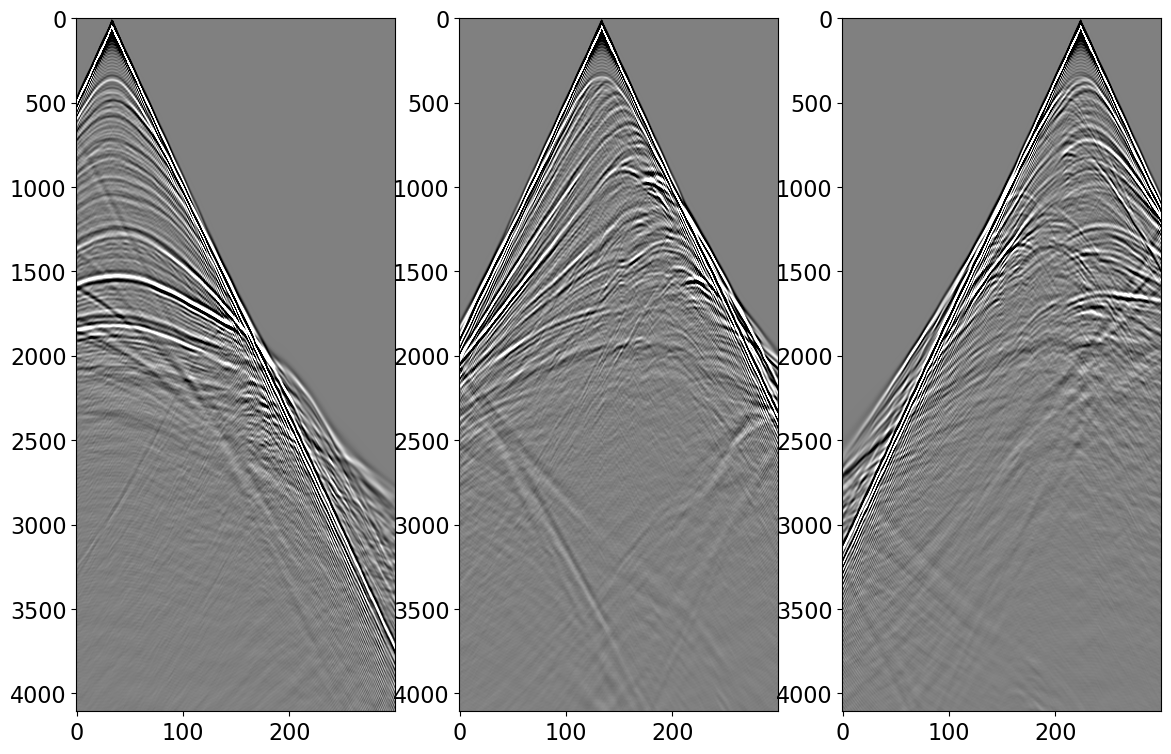

In [10]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

## Gradient validation

In [11]:
# Define loss as simple unweighted L2 difference of observed and modelled data
l2loss = L2(Identity(int(np.prod(dobs.shape[1:]))), dobs.reshape(par['ns'], -1))

ainv = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vprange=(vp_true.min(), vp_true.max()),
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      loss=l2loss)

  0%|          | 0/20 [00:00<?, ?it/s]

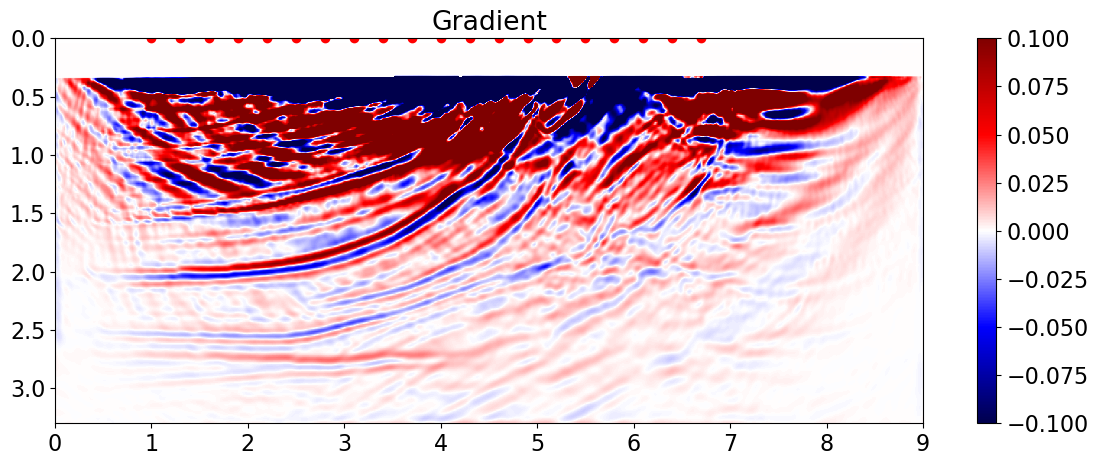

In [13]:
# Compute first gradient and find scaling with standard _loss_grad
postproc = PostProcessVP(scaling=1, mask=msk)
loss, direction = ainv._loss_grad(vp_init, postprocess=postproc.apply)

scaling = direction.max()

plt.figure(figsize=(14, 5))
plt.imshow(direction.T / scaling, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Gradient')
plt.axis('tight');

  0%|          | 0/20 [00:00<?, ?it/s]

4.1797176925109174e-07 tensor(4.1797e-07, dtype=torch.float64, grad_fn=<_TorchOperatorBackward>)


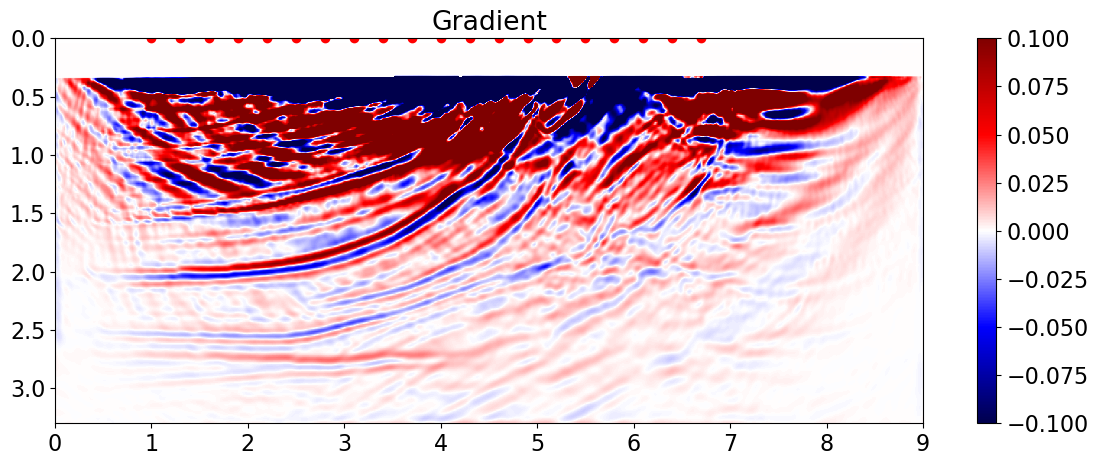

In [14]:
# Compute first gradient and find scaling with Torch autograd
postproc = PostProcessVP(scaling=1, mask=msk)
ainv_torch = TorchOperator(ainv.loss_grad, kwargs_prop=dict(postprocess=postproc.apply))

vp_init_torch = torch.from_numpy(vp_init)
vp_init_torch.requires_grad = True
loss_torch = ainv_torch.apply(vp_init_torch)
loss_torch.backward()
direction_torch = vp_init_torch.grad.numpy()

print(loss, loss_torch)

scaling_torch = direction_torch.max()

plt.figure(figsize=(14, 5))
plt.imshow(direction_torch.T / scaling_torch, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Gradient')
plt.axis('tight');

## Inversion with Torch ADAM

In [15]:
# FWI with Adam optimizer
maxiter = 100

# Define velocity model to invert for
vp_inv_torch = torch.from_numpy(vp_init)
vp_inv_torch.requires_grad = True

# Define FWI 
postproc = PostProcessVP(scaling=scaling, mask=msk)
ainv_torch = TorchOperator(ainv.loss_grad, kwargs_prop=dict(postprocess=postproc.apply))

optimizer = torch.optim.Adam([vp_inv_torch, ], lr=1e-2)

loss_history = []
vp_error_history = []
for iter in tqdm(range(maxiter)):
    optimizer.zero_grad()

    # Compute gradient
    loss = ainv_torch.apply(vp_inv_torch)
    loss.backward()
    
    # Update model
    optimizer.step()

    # Store history of loss and model error
    loss_history.append(loss.item())
    fwi_callback(vp_inv_torch.clone().detach().numpy().ravel(), vp=vp_true, vp_error=vp_error_history)

    print(f'Iteration {iter}, Loss {loss_history[-1]}')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 0, Loss 1259.6653851710864


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 1, Loss 1083.7155346433287


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 2, Loss 960.8600724052114


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 3, Loss 879.3028390849369


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 4, Loss 820.823329367178


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 5, Loss 772.1029902989862


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 6, Loss 727.1601222932851


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 7, Loss 684.6258361404298


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 8, Loss 644.9540405671974


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 9, Loss 608.1969869346617


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 10, Loss 573.9814066925321


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 11, Loss 542.5524004063916


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 12, Loss 514.452841744241


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 13, Loss 489.59914429003067


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 14, Loss 467.5104483451876


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 15, Loss 447.86628377567786


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 16, Loss 430.14386980984233


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 17, Loss 413.4535868828575


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 18, Loss 397.22510831616603


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 19, Loss 381.4453476445307


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 20, Loss 366.14105574878465


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 21, Loss 351.2088986113411


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 22, Loss 336.750682563613


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 23, Loss 323.0219344371342


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 24, Loss 310.1125288122913


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 25, Loss 297.9834713329711


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 26, Loss 286.52375730528496


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 27, Loss 275.56510069769524


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 28, Loss 265.14625348166874


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 29, Loss 255.43827730932233


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 30, Loss 246.38349017743903


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 31, Loss 237.7848172272823


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 32, Loss 229.48941306617309


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 33, Loss 221.43276323356437


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 34, Loss 213.72364473542154


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 35, Loss 206.43909903385375


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 36, Loss 199.5292653543191


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 37, Loss 192.94781229274304


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 38, Loss 186.6077871224599


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 39, Loss 180.49648624057662


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 40, Loss 174.6478513690766


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 41, Loss 169.02405064807735


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 42, Loss 163.6263851892778


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 43, Loss 158.468502067089


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 44, Loss 153.57198047806477


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 45, Loss 148.88716328033004


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 46, Loss 144.32983855149985


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 47, Loss 139.904318218408


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 48, Loss 135.63418021982298


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 49, Loss 131.5458273838431


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 50, Loss 127.62953565855128


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 51, Loss 123.89549496749517


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 52, Loss 120.3436280912815


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 53, Loss 116.94816010204455


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 54, Loss 113.67480531755109


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 55, Loss 110.51335527755194


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 56, Loss 107.48280911642429


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 57, Loss 104.58165382071581


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 58, Loss 101.7963111051537


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 59, Loss 99.1166231814405


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 60, Loss 96.55148517030946


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 61, Loss 94.0915669001005


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 62, Loss 91.72569714451993


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 63, Loss 89.45082195664578


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 64, Loss 87.269041554204


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 65, Loss 85.16665002890548


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 66, Loss 83.13255322904793


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 67, Loss 81.16070650438013


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 68, Loss 79.2524246282428


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 69, Loss 77.41067007091819


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 70, Loss 75.63437718668816


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 71, Loss 73.9214743718919


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 72, Loss 72.27044790016197


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 73, Loss 70.67872550554101


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 74, Loss 69.14202439905453


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 75, Loss 67.66043930422374


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 76, Loss 66.2311865548724


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 77, Loss 64.85353128859


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 78, Loss 63.52867032116828


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 79, Loss 62.25454445978044


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 80, Loss 61.02846042438258


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 81, Loss 59.850239078717


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 82, Loss 58.718199972214926


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 83, Loss 57.62717317192969


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 84, Loss 56.575634465308006


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 85, Loss 55.562978893084654


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 86, Loss 54.58597641816399


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 87, Loss 53.6420904417006


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 88, Loss 52.73068838555679


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 89, Loss 51.85062935773572


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 90, Loss 50.99960377386618


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 91, Loss 50.176371151184824


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 92, Loss 49.37990099040213


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 93, Loss 48.60802785397636


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 94, Loss 47.86008389424471


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 95, Loss 47.135279121671644


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 96, Loss 46.431829908083316


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 97, Loss 45.74890038738575


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 98, Loss 45.08540723035927


  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 99, Loss 44.440272157120155


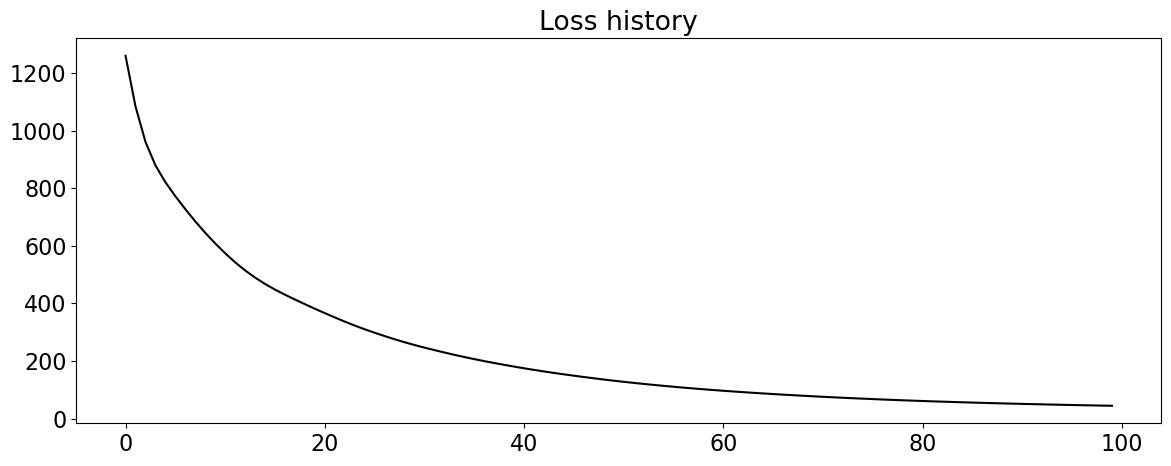

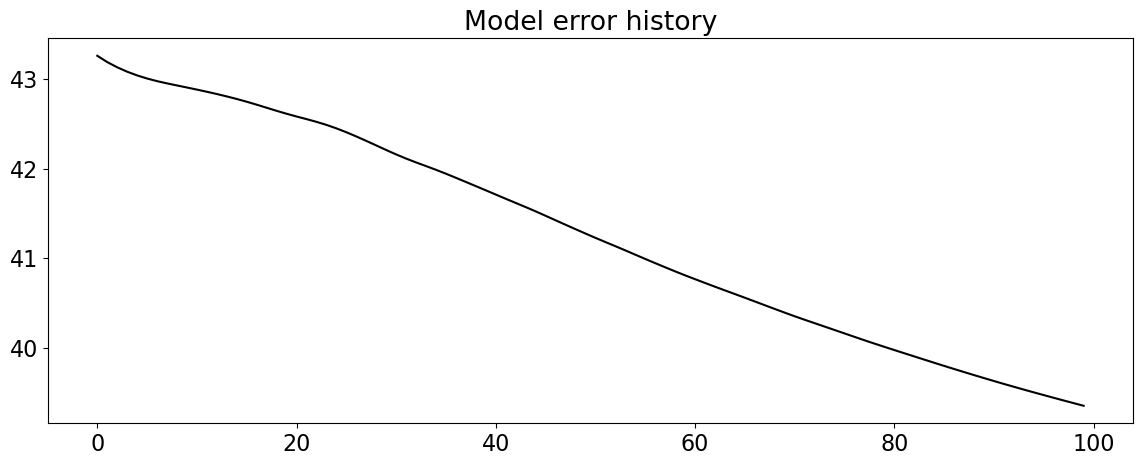

In [16]:
plt.figure(figsize=(14, 5))
plt.plot(loss_history, 'k')
plt.title('Loss history')

plt.figure(figsize=(14, 5))
plt.plot(vp_error_history, 'k')
plt.title('Model error history');

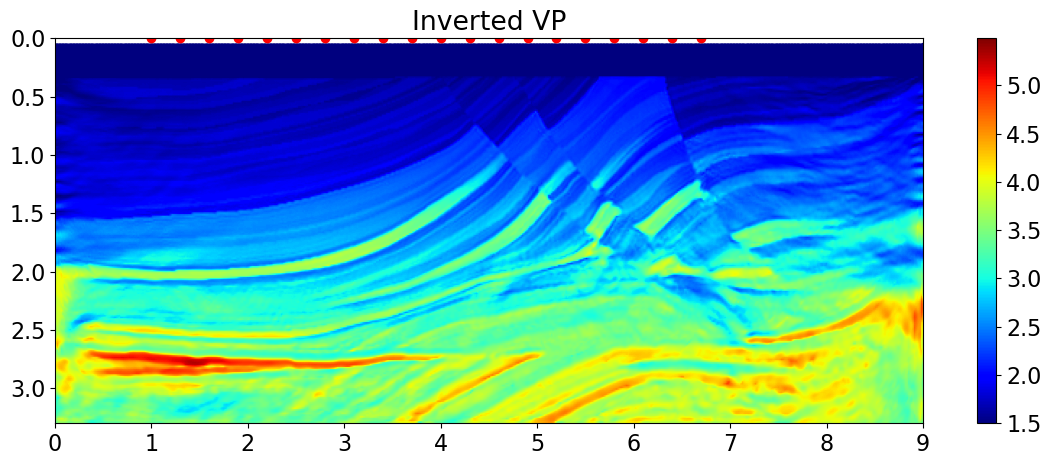

In [17]:
vp_inv = vp_inv_torch.detach().numpy()

plt.figure(figsize=(14, 5))
plt.imshow(vp_inv.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Inverted VP')
plt.axis('tight');

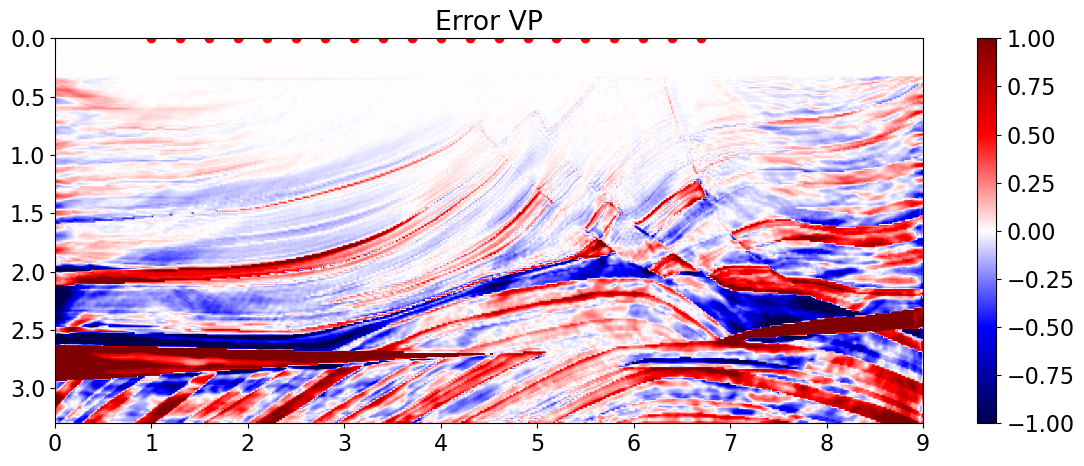

In [18]:
plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T-vp_inv.T, vmin=-1, vmax=1, cmap='seismic', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Error VP')
plt.axis('tight');

In [19]:
# Model data with inverted velocity model and compare with observed data
ainvfinal = AcousticWave2D(shape, origin, spacing, 
                           x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                           0., tmax,  
                           vp=vp_inv, 
                           src_type="Ricker", f0=par['freq'],
                           space_order=space_order, nbl=nbl)

dinv = ainvfinal.mod_allshots(dt=dtobs)[0]

  0%|          | 0/20 [00:00<?, ?it/s]

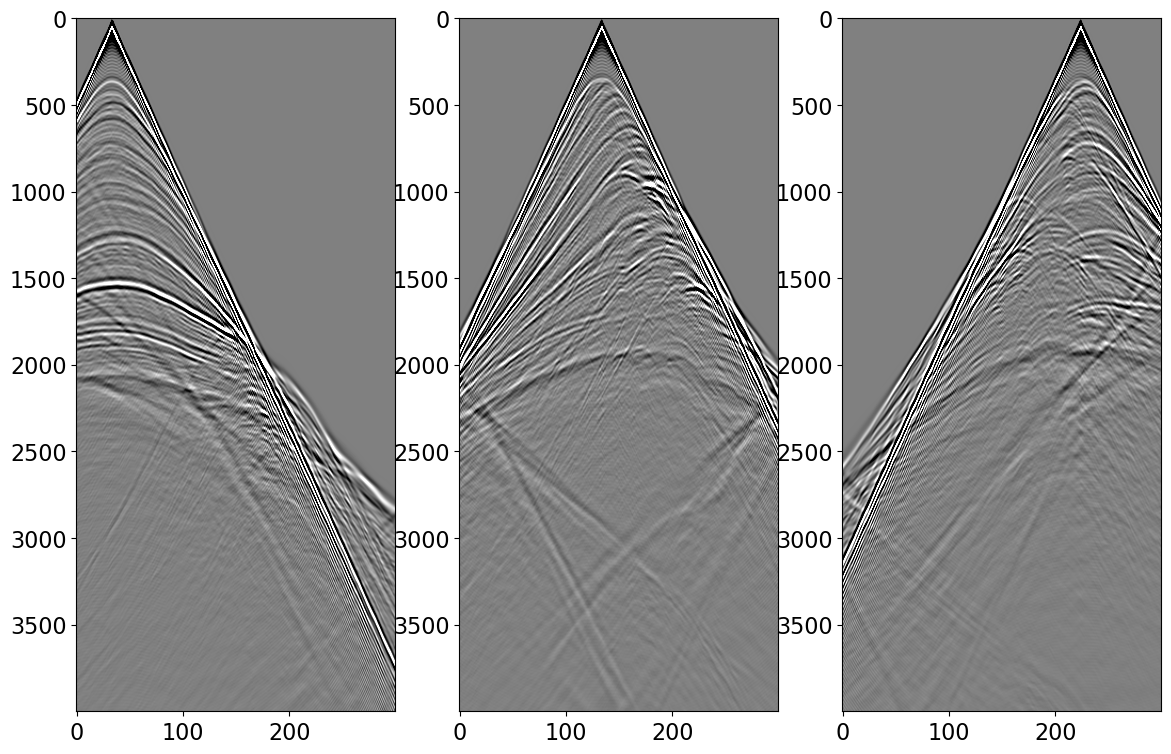

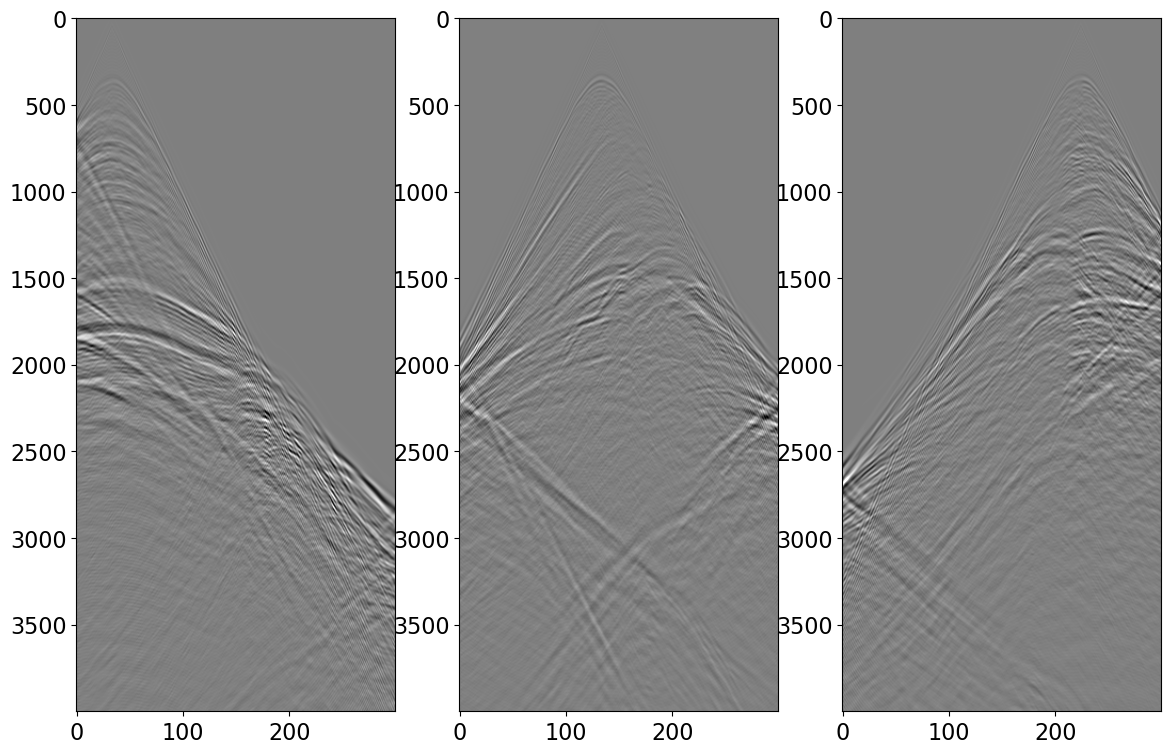

In [20]:
ntmax = 4000
d_vmin, d_vmax = np.percentile(np.hstack(dinv).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dinv[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot, :ntmax] - dinv[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)